# Logistic Regression -> `train_model_v1.ipynb`

This is the intial training run. How this goes will dictate how I proceed.

## Import Packages

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc


## Load extracted features CSV

In [28]:
df = pd.read_csv("../../data/metasploit_mixed_0.csv")

## Get Info 

In [29]:
df.head()

,ip.proto,frame.len,src_ip,dst_ip,c2_label,is_SYN,is_ACK,is_RST,is_FIN,is_PSH,is_URG,time_since_last,delta_t_ratio,rolling_mean_delta_t_3,rolling_std_delta_t_3,rolling_mean_delta_t_5,rolling_std_delta_t_5,rolling_mean_delta_t_10,rolling_std_delta_t_10
0,6,54,0,1,0,0,1,0,1,0,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,17,342,0,0,0,0,0,0,0,0,0,0.478708,1.000000,0.239354,0.338498,0.239354,0.338498,0.239354,0.338498
2,6,3163,0,1,0,0,1,0,0,1,0,0.689579,1.440500,0.389429,0.353352,0.389429,0.353352,0.389429,0.353352
3,6,3232,0,1,0,0,1,0,0,1,0,0.000403,0.000584,0.389563,0.353130,0.292173,0.347957,0.292173,0.347957
4,6,92,0,1,0,0,1,0,0,1,0,0.000129,0.320099,0.230037,0.397975,0.233764,0.328425,0.233764,0.328425


In [30]:
df.info()
df["c2_label"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138379 entries, 0 to 138378
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ip.proto                 138379 non-null  int64  
 1   frame.len                138379 non-null  int64  
 2   src_ip                   138379 non-null  int64  
 3   dst_ip                   138379 non-null  int64  
 4   c2_label                 138379 non-null  int64  
 5   is_SYN                   138379 non-null  int64  
 6   is_ACK                   138379 non-null  int64  
 7   is_RST                   138379 non-null  int64  
 8   is_FIN                   138379 non-null  int64  
 9   is_PSH                   138379 non-null  int64  
 10  is_URG                   138379 non-null  int64  
 11  time_since_last          138379 non-null  float64
 12  delta_t_ratio            138379 non-null  float64
 13  rolling_mean_delta_t_3   138379 non-null  float64
 14  roll

c2_label
0    136772
1      1607
Name: count, dtype: int64

## Preprocessing

In [31]:
# Separate Predictors and Target Variable
X = df.drop(columns=["c2_label"]) # predictors
y = df["c2_label"] # target variable

In [32]:
# Normalize the Predictors
scaler = StandardScaler() # initialize the scaler

X_scaled = scaler.fit_transform(X) # fit the scaler to the data and transform X

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=32, stratify=y) # pick 30% of the data for testing, make sure ratio of classes is the same in the training and testing sets

print(f"Training size: {X_train.shape}, Testing size: {X_test.shape}")


Training size: (96865, 18), Testing size: (41514, 18)


## Train

In [33]:
# Train the Model
model = LogisticRegression(max_iter=1000) # initialize the model
model.fit(X_train, y_train) # train the model

LogisticRegression(max_iter=1000)

In [35]:
# Evaluate Model Performance
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9884


## Post-Training Visualizations

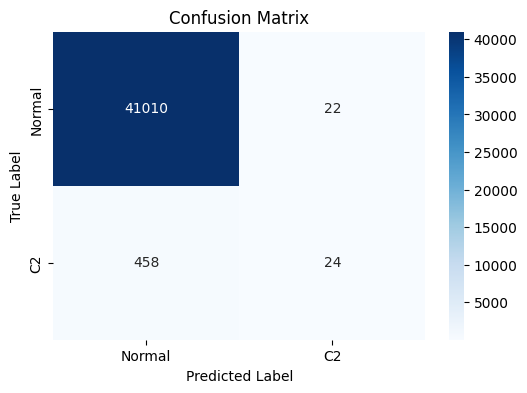

In [36]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "C2"], yticklabels=["Normal", "C2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [38]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     41032
           1       0.52      0.05      0.09       482

    accuracy                           0.99     41514
   macro avg       0.76      0.52      0.54     41514
weighted avg       0.98      0.99      0.98     41514



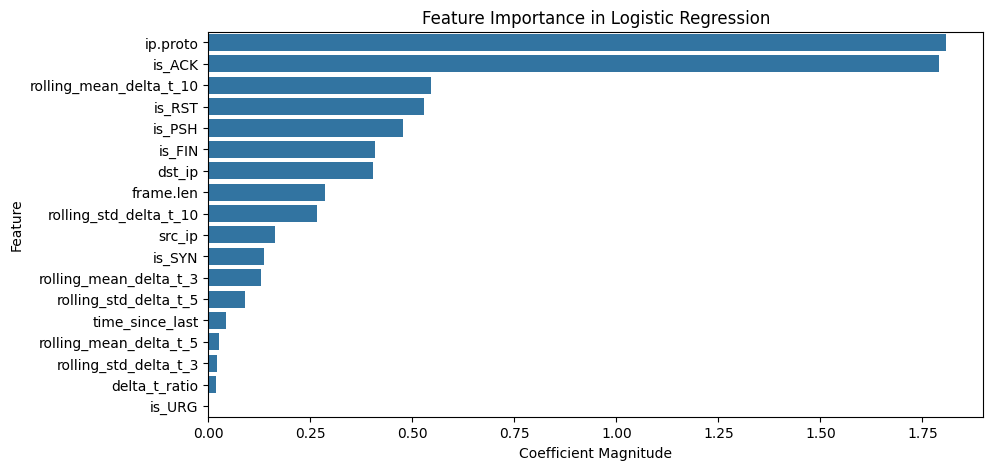

In [39]:
# Feature Importance
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": np.abs(model.coef_[0])})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance in Logistic Regression")
plt.show()

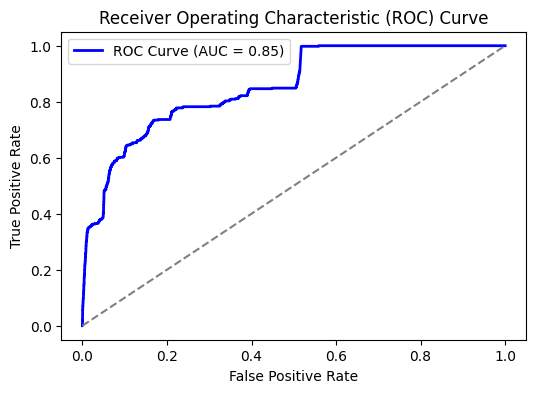

In [41]:
## ROC Curve and AUC Score
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

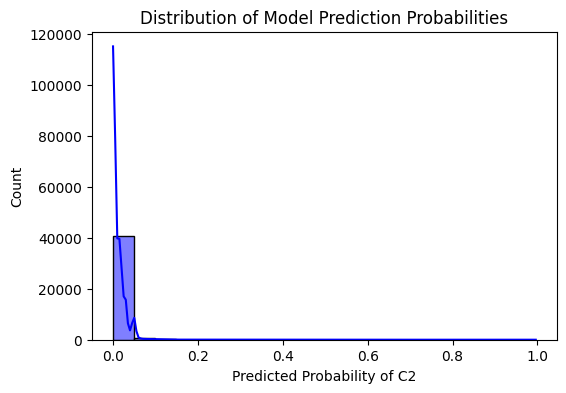

In [42]:
# Histogram of Predicted Probabilities
plt.figure(figsize=(6,4))
sns.histplot(model.predict_proba(X_test)[:, 1], bins=20, kde=True, color="blue")
plt.xlabel("Predicted Probability of C2")
plt.ylabel("Count")
plt.title("Distribution of Model Prediction Probabilities")
plt.show()
